In [ ]:
##### SETUP for older versions of tensorflow...
##### Only to get the VGGFace2
!pip install git+https://github.com/rcmalli/keras-vggface.git
!pip install keras_vggface
!pip install keras_application
!pip install keras_preprocessing
!pip uninstall -y tensorflow
!pip install tensorflow-gpu==1.14.0
!pip install keras==2.2.4

  Cloning https://github.com/rcmalli/keras-vggface.git to /tmp/pip-req-build-p3mfqec7
  Running command git clone -q https://github.com/rcmalli/keras-vggface.git /tmp/pip-req-build-p3mfqec7
  Created wheel for keras-vggface: filename=keras_vggface-0.6-cp37-none-any.whl size=8312 sha256=750bc7ad8ddd94cd5f5aaaea4d43d2c72df5163d5ffadb7000b1ab06c3278aa9
  Stored in directory: /tmp/pip-ephem-wheel-cache-cwlm0p9p/wheels/36/07/46/06c25ce8e9cd396dabe151ea1d8a2bc28dafcb11321c1f3a6d
Successfully built keras-vggface
ERROR: Could not find a version that satisfies the requirement keras_application (from versions: none)
ERROR: No matching distribution found for keras_application
Uninstalling tensorflow-2.4.1:
  Successfully uninstalled tensorflow-2.4.1
     |████████████████████████████████| 377.1MB 41kB/s 
     |████████████████████████████████| 491kB 52.6MB/s 
     |████████████████████████████████| 3.2MB 65.7MB/s 
     |████████████████████████████████| 51kB 8.9MB/s 
  Found existing installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


!mkdir affectnet
!mkdir affectnet/train
!mkdir affectnet/validation

!cp drive/MyDrive/Colab/affectnet/train_set.tar train_set.tar
!cp drive/MyDrive/Colab/affectnet/val_set.tar val_set.tar

Mounted at /content/drive


In [ ]:
import shutil

shutil.rmtree("affectnet/validation")
shutil.rmtree("affectnet/train")

!mkdir affectnet
!mkdir affectnet/train
!mkdir affectnet/validation

!tar -xvf 'val_set.tar' -C affectnet/validation/
!tar -xvf 'train_set.tar' -C affectnet/train/

Streaming af output blev afkortet til de sidste 5000 linjer.
train_set/annotations/124267_val.npy
train_set/annotations/376254_val.npy
train_set/annotations/39740_val.npy
train_set/annotations/81084_val.npy
train_set/annotations/254387_val.npy
train_set/annotations/285759_aro.npy
train_set/annotations/357609_exp.npy
train_set/annotations/252963_exp.npy
train_set/annotations/269949_exp.npy
train_set/annotations/313951_lnd.npy
train_set/annotations/133985_val.npy
train_set/annotations/286684_aro.npy
train_set/annotations/312951_exp.npy
train_set/annotations/71243_aro.npy
train_set/annotations/97445_aro.npy
train_set/annotations/111064_lnd.npy
train_set/annotations/274110_aro.npy
train_set/annotations/89691_exp.npy
train_set/annotations/9571_val.npy
train_set/annotations/225425_val.npy
train_set/annotations/16111_val.npy
train_set/annotations/413057_aro.npy
train_set/annotations/149627_val.npy
train_set/annotations/302209_aro.npy
train_set/annotations/295055_aro.npy
train_set/annotations/

In [ ]:
import os
import numpy as np
import pandas as pd
basePath = "affectnet/train/train_set/annotations"
imgPath = "affectnet/train/train_set/images/"
_, _, files = next(os.walk(basePath))
train = []

for file in files:
  filePath = os.path.join(basePath, file)
  if file.split('_')[1][0:3] == "aro":
    if os.path.exists(os.path.join(basePath, file.split('_')[0]+"_val.npy")):
      arousal = (float(np.load(os.path.join(basePath, file.split('_')[0]+"_aro.npy"))) + 1 ) / 2
      valence = (float(np.load(os.path.join(basePath, file.split('_')[0]+"_val.npy"))) + 1 ) / 2
      train.append([file.split('_')[0]+".jpg", valence, arousal])
dfTrain = pd.DataFrame(train, columns=['path', 'val', 'aro'])
print(dfTrain.head())

basePath = "affectnet/validation/val_set/annotations"
imgPath = "affectnet/validation/val_set/images/"
_, _, files = next(os.walk(basePath))
validation = []
for file in files:
  filePath = os.path.join(basePath, file)
  if file.split('_')[1][0:3] == "aro":
    if os.path.exists(os.path.join(basePath, file.split('_')[0]+"_val.npy")):
      arousal = (float(np.load(os.path.join(basePath, file.split('_')[0]+"_aro.npy"))) + 1 ) / 2
      valence = (float(np.load(os.path.join(basePath, file.split('_')[0]+"_val.npy"))) + 1 ) / 2
      validation.append([file.split('_')[0]+".jpg", valence, arousal])
dfVal = pd.DataFrame(validation, columns=['path', 'val', 'aro'])
print(dfVal.head())

         path       val       aro
0  360237.jpg  0.338115  0.818788
1  229883.jpg  0.138889  0.301588
2   53935.jpg  0.416666  0.825397
3   89802.jpg  0.311266  0.918602
4  301079.jpg  0.862950  0.521777
       path       val       aro
0  2691.jpg  0.440476  0.896826
1  2206.jpg  0.115297  0.467463
2   921.jpg  0.242063  0.630953
3  1130.jpg  0.117692  0.657278
4  2728.jpg  0.182540  0.738095


In [ ]:
import numpy as np
import os
import tensorflow as tf
import numpy as np
from keras.preprocessing.image import ImageDataGenerator, load_img, NumpyArrayIterator
from keras.layers import Conv2D, Dense, BatchNormalization, Activation, Dropout, MaxPooling2D, Flatten
from keras.optimizers import Adam, RMSprop, SGD
from keras import regularizers
from keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard, EarlyStopping, ReduceLROnPlateau
import keras
from keras.models import Model
from google.colab import drive


#config = ConfigProto()
#config.gpu_options.allow_growth = True
#session = InteractiveSession(config=config)

In [ ]:
train=ImageDataGenerator(rescale=1./255., 
                         zoom_range=0.2,
                        horizontal_flip=True,
                         validation_split=0.2,)
train_generator=train.flow_from_dataframe(dataframe=dfTrain,
                                            directory="affectnet/train/train_set/images",
                                            x_col="path",
                                            y_col=["val", "aro"],
                                            subset="training",
                                            batch_size=64,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

validation_generator=train.flow_from_dataframe(dataframe=dfTrain,
                                            directory="affectnet/train/train_set/images",
                                            x_col="path",
                                            y_col=["val", "aro"],
                                            subset="validation",
                                            batch_size=64,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

test=ImageDataGenerator(rescale=1./255.)
test_generator=test.flow_from_dataframe(dataframe=dfVal,
                                            directory="affectnet/validation/val_set/images",
                                            x_col="path",
                                            y_col=["val", "aro"],
                                            subset=None,
                                            batch_size=64,
                                            seed=42,
                                            shuffle=True,
                                            class_mode="raw",
                                            target_size=(224,224))

Found 123278 validated image filenames.
Found 30819 validated image filenames.
Found 3999 validated image filenames.


In [ ]:
#COMMON setup
## Imports

### CCC implementations
def add_top_layer(model_base,output_classes):
  bottom_model = model_base.output
  """creates the top or head of the model that will be
  placed ontop of the bottom layers"""
  #This first line here is only for the SENet.
  #bottom_model = model_base.get_layer('avg_pool').output
  #For vgg16
  #out = vgg_model.get_layer(layer_name).output
  #vgg_model_new = Model(vgg_model.input, out)
  #bottom_model = model_base.get_layer('avg_pool').output
  bottom_model = Flatten(name="flatten")(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(1024,activation='relu')(bottom_model)
  bottom_model = Dropout(0.50)(bottom_model)
  bottom_model = Dense(output_classes,activation='sigmoid')(bottom_model)
  return bottom_model


import tensorflow.keras.backend as K

def ccc_loss(y_true, y_pred):
    return 1 - ((ccc_v(y_true, y_pred) + ccc_a(y_true, y_pred)) / 2)


def ccc_v(y_true, y_pred):
    """
    Concordance Correlation Coefficient for valence
    """
    x = y_true[:, 0]
    y = y_pred[:, 0]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc


def ccc_a(y_true, y_pred):
    """
    Concordance Correlation Coefficient for arousal
    """
    x = y_true[:, 1]
    y = y_pred[:, 1]
    mx = K.mean(x, axis=0)
    my = K.mean(y, axis=0)
    xm, ym = x - mx, y - my
    rho = K.sum(xm * ym) / (K.sqrt(K.sum(xm ** 2)) * K.sqrt(K.sum(ym ** 2)))
    x_s = K.std(x)
    y_s = K.std(y)
    ccc = 2 * rho * x_s * y_s / (x_s ** 2 + y_s ** 2 + (mx - my) ** 2)
    return ccc

print('completed')

completed


Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_8 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0   

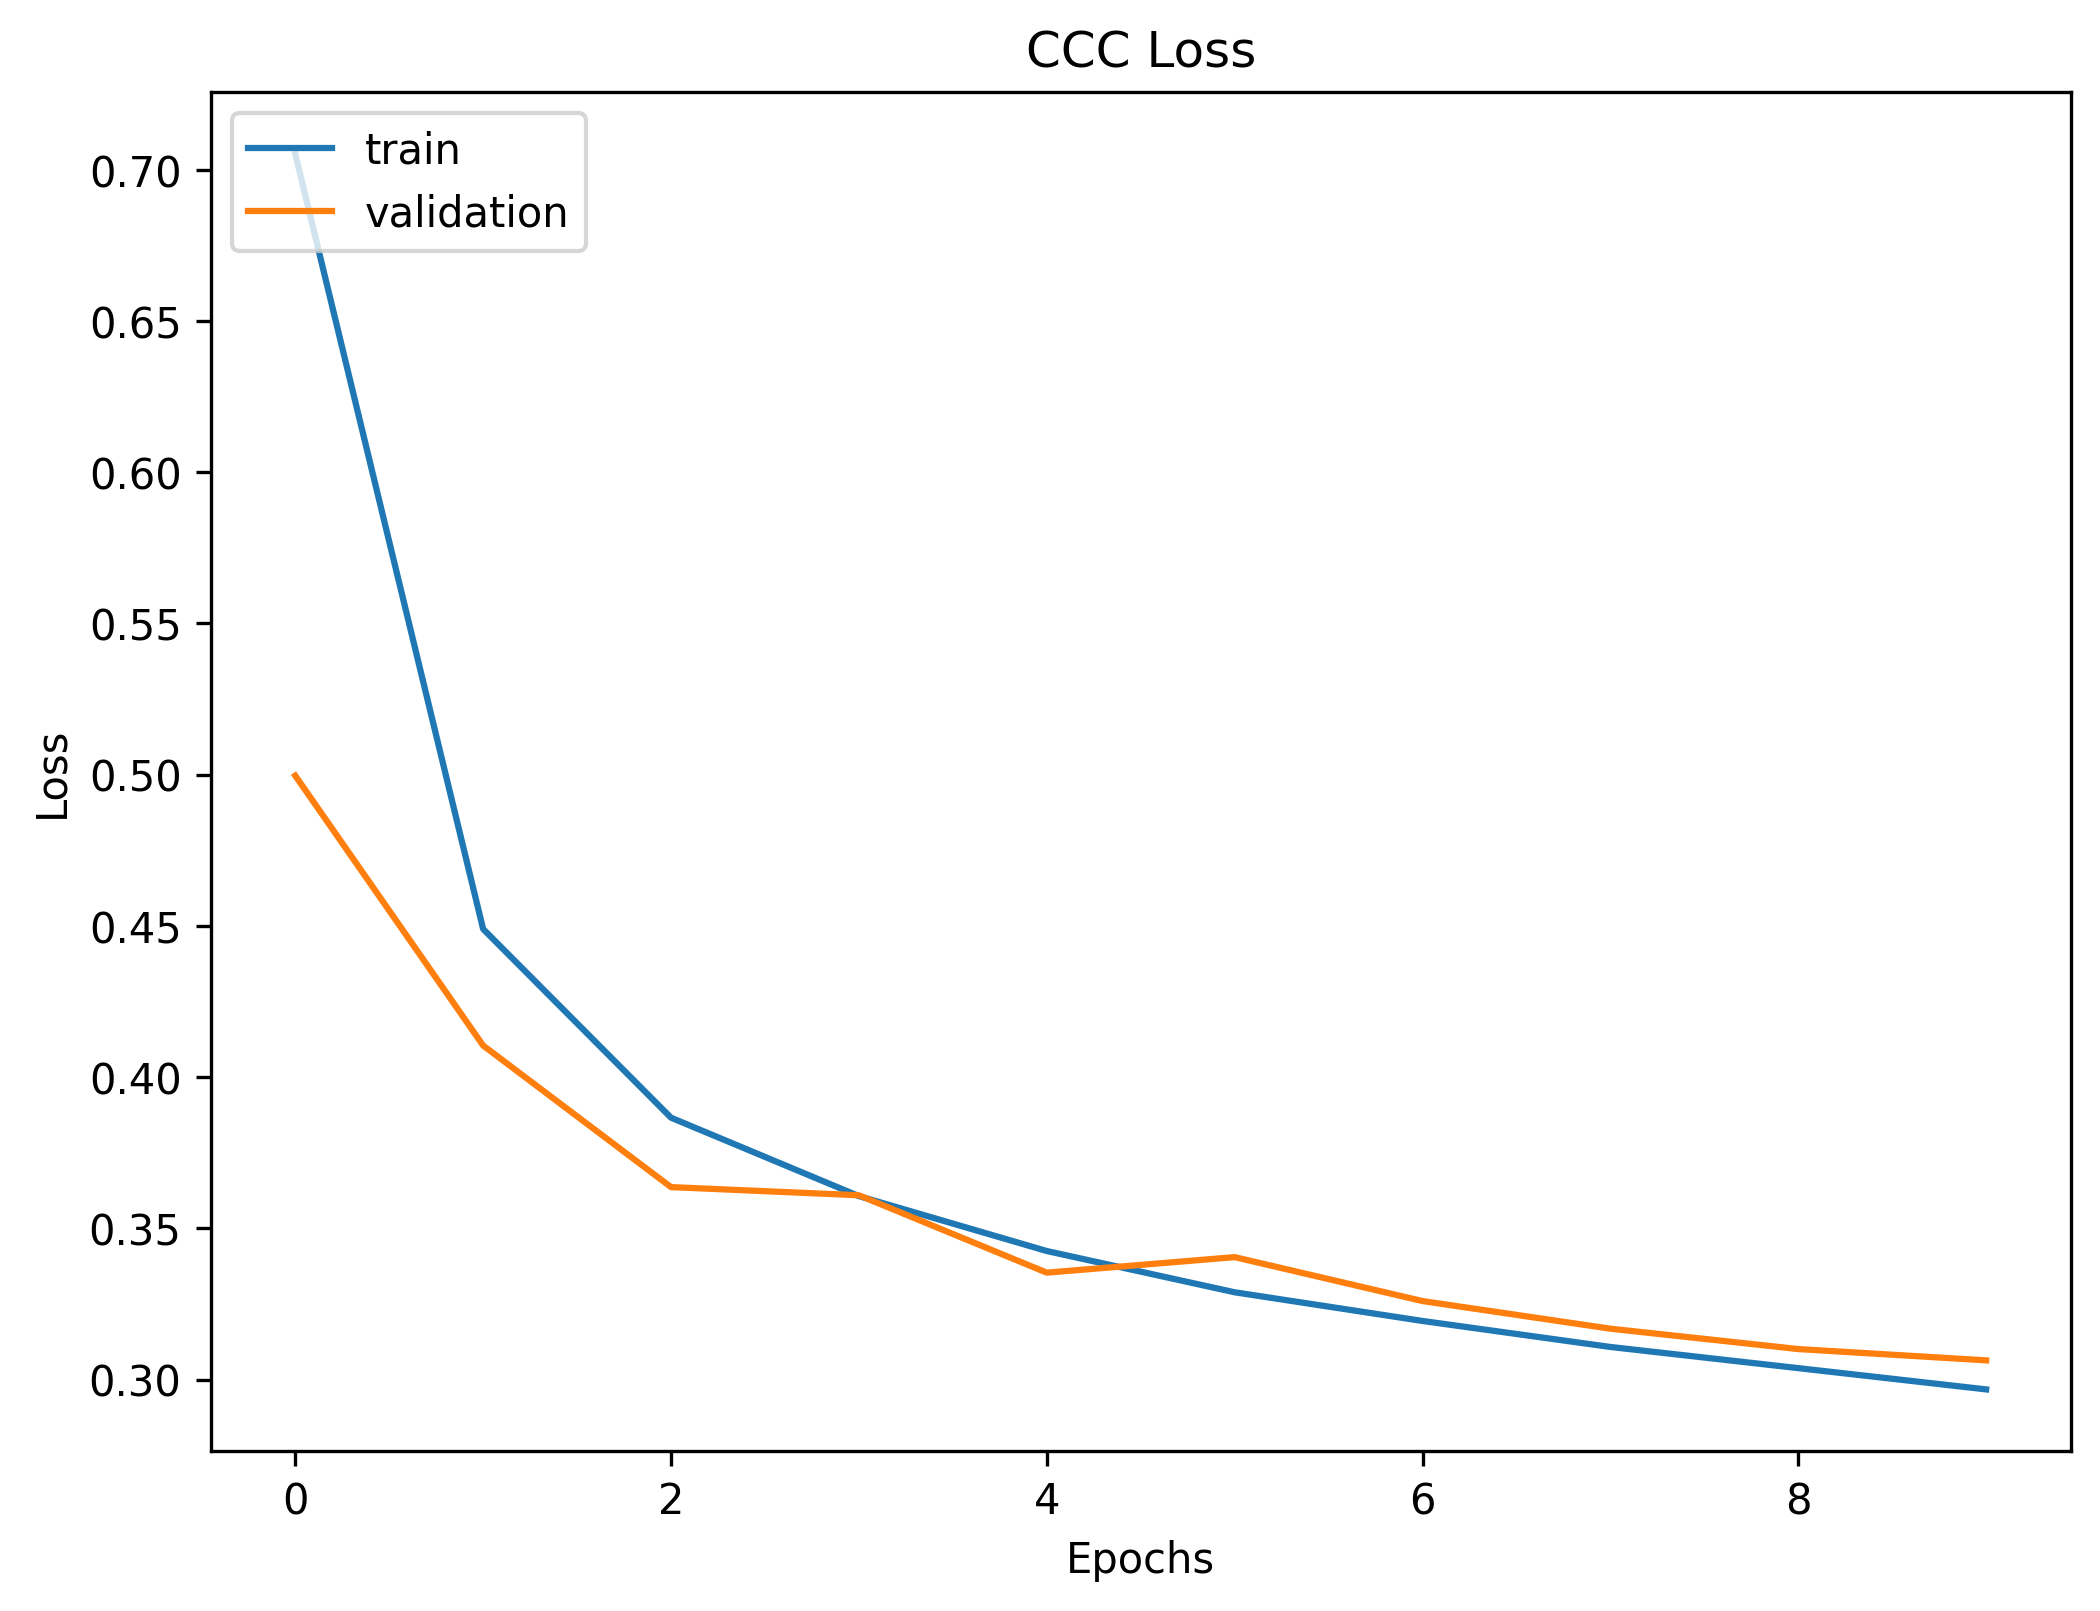

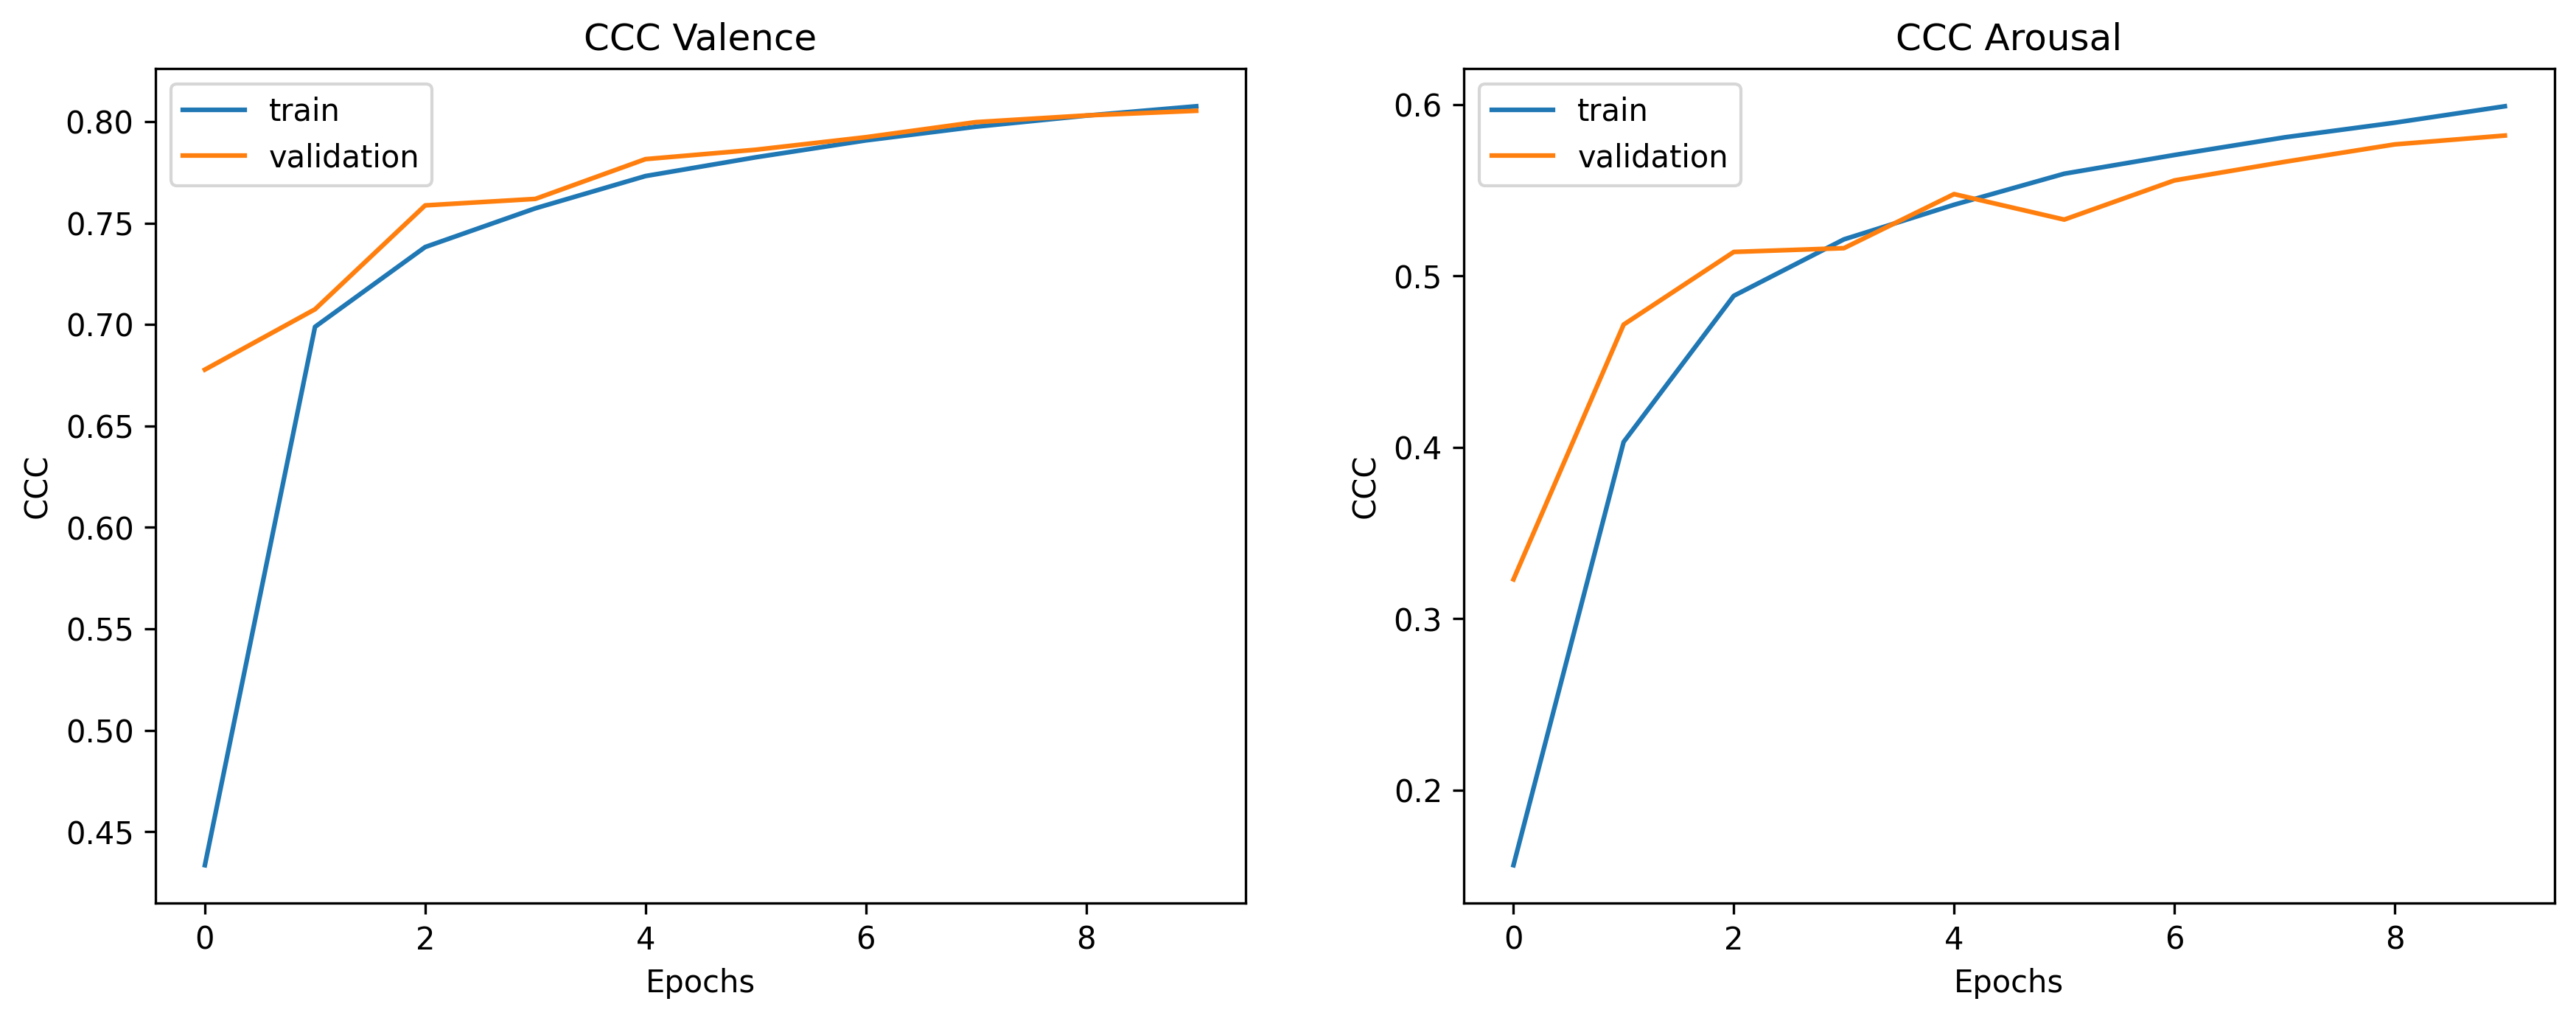

completed


In [15]:
#from keras_vggface.vggface import VGGFace
from keras.applications import vgg16
import datetime
#custom parameters
nb_class = 2
hidden_dim=1024

model_base = vgg16.VGG16(weights=None,include_top=False, input_shape=(224, 224, 3))
for layers in model_base.layers:
  layers.trainable = True
#last_layer = model_base.get_layer('pool5').output
#x = Flatten(name='flatten')(last_layer)
#x = Dense(hidden_dim, activation='relu', name='fc6')(x)
#x = Dense(hidden_dim, activation='relu', name='fc7')(x)
#out = Dense(nb_class, activation='sigmoid', name='fc8')(x)
#model = Model(model_base.input, out)

NAME_OF_MODEL="VGG16_t_224"

#model=vgg16.VGG16(include_top=True, weights=None,    input_shape=(224,224,3),classes=2,
#    classifier_activation='sigmoid')
#Finalizing the model:
#from keras_vggface.vggface import VGGFace

#model_base = VGGFace(model='resnet50',include_top=False, input_shape=(224, 224, 3), pooling='avg') # pooling: None, avg or max

#print(model_base.summary())
model=model_base
## adding the regression layer on top
model_head=add_top_layer(model_base,2)
#Connecting the two models
model=Model(inputs=model_base.input,outputs=model_head)
print(model.summary())



opt = Adam(lr=0.0001, decay=1e-6)
#Selecting loss and metrics
model.compile(optimizer=opt, loss=ccc_loss, metrics=[ccc_v, ccc_a])
#Printing model summary

PATH="/content/drive/MyDrive/Colab/AffectNet/"
chk_path = PATH+NAME_OF_MODEL+'.h5'
log_dir = PATH+"checkpoint/logs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

checkpoint = ModelCheckpoint(filepath=chk_path,
                               save_best_only=True,
                               verbose=1,
                               mode='min',
                               monitor='val_loss')

earlystop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=3,
                            verbose=1,
                            restore_best_weights=True)

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                factor=0.2,
                                patience=6,
                                verbose=1,
                                min_delta=0.0001)

steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
csv_logger = CSVLogger(PATH+'training'+NAME_OF_MODEL+'.log')

callback = [checkpoint, reduce_lr, csv_logger]
print(steps_per_epoch)
print(validation_steps)

with tf.device('/device:GPU:0'):
  epochs=10
  #### fit_generator is only to use it together with tensorflow 1.14 and VGGFace2 dataset.
  model_hist = model.fit(train_generator,
                  validation_data=validation_generator,
                  epochs=epochs,
                  callbacks=callback,
                  steps_per_epoch=steps_per_epoch,
                  validation_steps=validation_steps)



##Loading weigths 
PATH="/content/drive/MyDrive/Colab/AffectNet/"
# Load the previously saved weights
#model.load_weights(PATH+NAME_OF_MODEL+'.h5')

#Loading the Data_set
# Change data_src variable as per your drive
data_src = '/content/drive/MyDrive/Colab/AffectNet'

#Loading the data into the correct format:
test_faces = np.load(data_src+'/validation_images.npy')/255
test_labels = (np.load(data_src+'/validation_annotations.npy')+1)/2
#Only for grayscale.
#from sklearn.model_selection import train_test_split

#x_test, _, y_test, _ = train_test_split(test_faces, test_labels, test_size=0.001, shuffle= True)
#train_datagen = ImageDataGenerator(rescale=1./255)

#training_set=train_datagen.flow(x_test,y_test,batch_size=64)
print(test_labels)

#Executing tests
print("Evaluate on test data")

results = model.evaluate(x=test_faces, y=test_labels, batch_size=64)
print("test loss, test acc:", results)
###

#figures
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 300
plt.figure(figsize=(8,6))
plt.plot(model_hist.history['loss'])
plt.plot(model_hist.history['val_loss'])
plt.title('CCC Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

###Results for the model
### PLOTTING OF CCC SCORE
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)

plt.plot(model_hist.history['ccc_v'])
plt.plot(model_hist.history['val_ccc_v'])
plt.title('CCC Valence')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')

plt.subplot(1,2,2)
plt.plot(model_hist.history['ccc_a'])
plt.plot(model_hist.history['val_ccc_a'])
plt.title('CCC Arousal')
plt.xlabel('Epochs')
plt.ylabel('CCC')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

print('completed')